# [GD2] 없다면 어떻게 될까? (ResNet Ablation Study)  
  
### 실습목표  
직접 ResNet 구현하기  
모델을 config에 따라서 변경가능하도록 만들기  
직접 실험해서 성능 비교하기

## 2. Ablation Study 실습 (1) CIFAR-10 데이터셋 준비하기  
  
### 1) CIFAR-10
```
$ pip install tensorflow-datasets
```

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tf.__version__

'2.3.0'

* 데이터셋이 준비되면 클래스의 수와 클래스에 따른 이름을 볼 수 있습니다. DatasetBuilder의 info를 통해 정보를 확인해 보세요.
  
* tfds.load()는 기본적으로 ~/tensorflow_datasets 경로에 데이터셋을 다운로드합니다. 데이터셋 크기가 커서 하나의 폴더에 모아놓고 사용하는 것도 좋은 방법이므로, ~/aiffel 프로젝트 폴더가 아닌 기본 경로에 다운 받아 사용하시면 됩니다. 혹시 데이터셋 경로를 바꾸고 싶으시다면, data_dir 인자를 사용하세요.

In [4]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [5]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [6]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


### 2) Input Normalization2) Input Normalization  
* 딥러닝 용어 정리, Normalization(정규화) 설명 : (https://light-tree.tistory.com/132)  
* 우리는 "가로 1920, 세로 1080 픽셀의 이미지"처럼 픽셀의 수를 사용해 이미지의 크기를 말할 수 있는데요. 이때 한 픽셀이 가진 채널(channel) 값은 픽셀의 색을 표현합니다. RGB는 Red, Green, Blue로 세 가지 색을 조합해서 우리가 보는 다양한 색을 만들어내는 방법이죠. 그레이 스케일(gray scale)은 단순하게 흑과 백만을 표현하는 하나의 채널을 가진 이미지입니다. RGB나 그레이 스케일 외에도 HSV, CMYK 등 인쇄 또는 이미지 작업을 위해 사용되는 다양한 채널 체계가 있습니다.  
* 우리의 모델에 넣어주기 전에는 각 채널별 최댓값인 255로 정규화(normalize)를 해주어 이미지의 표현이 0과 1 사이로 들어오도록 만들어줍니다.

In [7]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [8]:
def sendCommand(command, callback=None):
    if callback is None:
        callback = NetVend.blankCallback
    return NetVend.sendSignedCommand(command, NetVend.signCommand(command), callback)
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [9]:
ds_info.features["label"].num_classes

10

In [10]:
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

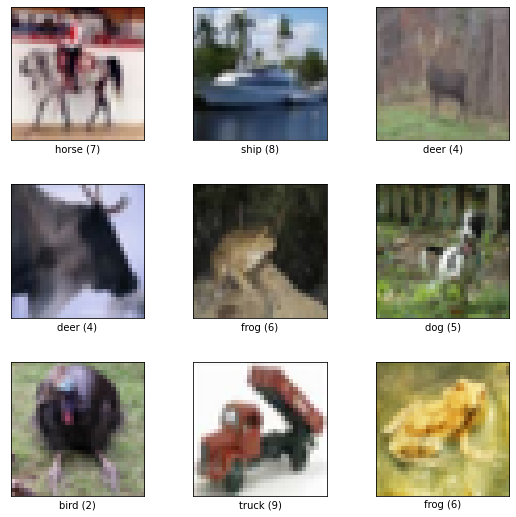

In [11]:
fig = tfds.show_examples(ds_train, ds_info)

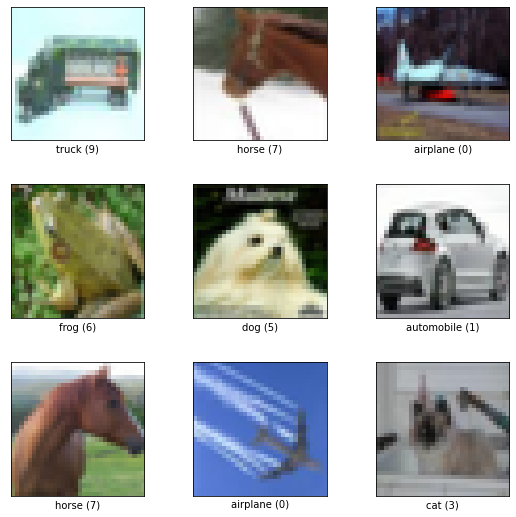

In [12]:
fig = tfds.show_examples(ds_test, ds_info)

## 프로젝트: ResNet Ablation Study  
  
* https://wiserloner.tistory.com/1157  
* https://eremo2002.tistory.com/76 (레즈넷 50 구현)
* https://dnddnjs.github.io/cifar10/2018/10/09/resnet/ (파이토치로 코드 구현)

### 1) ResNet 기본 블록 구성하기  
이제 실전으로 돌아와서 ResNet-34와 ResNet-50 네트워크를 직접 만든다고 생각해봅시다. 우선 ResNet-34와 ResNet-50에서 사용되는 블록의 공통점을 찾고 차이점을 찾아봅시다.  
* https://arxiv.org/pdf/1512.03385.pdf  
![Screenshot from 2021-04-09 03-21-40](https://user-images.githubusercontent.com/76797423/114077435-c4664680-98e2-11eb-958d-f487dd9060ae.png)

* 코드 참고 : https://towardsdatascience.com/understand-and-implement-resnet-50-with-tensorflow-2-0-1190b9b52691

In [13]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dense, BatchNormalization
from keras.layers import Add
#from keras.layers import Layer
from tensorflow.keras import layers

Using TensorFlow backend.


In [14]:
def identity_block(input_tensor, num_cnn, is_50, is_skip, channel, stage):
    bn_axis = 3
    x = input_tensor
    for i, cnn_num in enumerate(range(num_cnn)):  
        conv_name_base = 'stage' + str(stage+2) +'_'+ str(i+2) +'_'
        
        if is_50 is False:
            input_tensor = x
            x = layers.Conv2D(channel, (3,3),
                          padding='same',
                          kernel_initializer='he_normal',
                          name=conv_name_base + 'conv1')(x)
            x = layers.BatchNormalization(axis=bn_axis, name=conv_name_base + 'bn1')(x)
            x = layers.Activation('relu')(x)
            
            x = layers.Conv2D(channel, (3,3),
                              padding='same',
                              kernel_initializer='he_normal',
                              name=conv_name_base + 'conv2')(x)
            x = layers.BatchNormalization(axis=bn_axis, name=conv_name_base + 'bn2')(x)
            x = layers.Activation('relu')(x)
        
        elif is_50 is True:
            input_tensor = x 
            x = layers.Conv2D(channel, (1, 1),
                              kernel_initializer='he_normal',
                              name=conv_name_base + 'conv1')(input_tensor)
            x = layers.BatchNormalization(axis=bn_axis, name=conv_name_base + 'bn1')(x)
            x = layers.Activation('relu')(x)

            x = layers.Conv2D(channel, (3,3),
                              padding='same',
                              kernel_initializer='he_normal',
                              name=conv_name_base + 'conv2')(x)
            x = layers.BatchNormalization(axis=bn_axis, name=conv_name_base + 'bn2')(x)
            x = layers.Activation('relu')(x)

            x = layers.Conv2D(channel*4, (1, 1),
                              kernel_initializer='he_normal',
                              name=conv_name_base + 'conv3')(x)
            x = layers.BatchNormalization(axis=bn_axis, name=conv_name_base + 'bn3')(x)
            x = layers.Activation('relu')(x)
            
        if is_skip is True:
            x = layers.add([x, input_tensor], name=conv_name_base+'add')
        x = layers.Activation('relu')(x)
    return x

In [15]:
def conv_block(input_tensor, is_50, is_skip, channel, stage):
    conv_name_base = 'stage' + str(stage+2) + '_1_'
    bn_axis = 3
    if stage is 0:
        strides=(1,1)
    else:
        strides=(2,2)
        
    if is_50 is False:
        x = layers.Conv2D(channel, (3,3), strides=strides, padding='same', 
                          kernel_initializer='he_normal',
                          name=conv_name_base + 'conv1')(input_tensor)
        x = layers.BatchNormalization(axis=bn_axis, name=conv_name_base + 'bn1')(x)
        x = layers.Activation('relu')(x)
        
        x = layers.Conv2D(channel, (3,3), padding='same',
                          kernel_initializer='he_normal',
                          name=conv_name_base + 'conv2')(x)
        x = layers.BatchNormalization(axis=bn_axis, name=conv_name_base + 'bn2')(x)
        x = layers.Activation('relu')(x)
        
        shortcut = layers.Conv2D(channel, (1, 1), strides=strides,padding='same', 
                                 kernel_initializer='he_normal',
                                 name=conv_name_base + 'short')(input_tensor)
        shortcut = layers.BatchNormalization(
            axis=bn_axis, name=conv_name_base + 'bn3')(shortcut)
        
    elif is_50 is True:
        x = layers.Conv2D(channel, (1, 1), strides=strides,
                          kernel_initializer='he_normal',
                          name=conv_name_base + 'conv1')(input_tensor)
        x = layers.BatchNormalization(axis=bn_axis, name=conv_name_base + 'bn1')(x)
        x = layers.Activation('relu')(x)

        x = layers.Conv2D(channel, (3,3), padding='same',
                          kernel_initializer='he_normal',
                          name=conv_name_base + 'conv2')(x)
        x = layers.BatchNormalization(axis=bn_axis, name=conv_name_base + 'bn2')(x)
        x = layers.Activation('relu')(x)

        x = layers.Conv2D(channel*4, (1, 1),
                          kernel_initializer='he_normal',
                          name=conv_name_base + 'conv3')(x)
        x = layers.BatchNormalization(axis=bn_axis, name=conv_name_base + 'bn3')(x)
        x = layers.Activation('relu')(x)
        
        shortcut = layers.Conv2D(channel*4, (1, 1), strides=strides,
                                 kernel_initializer='he_normal',
                                 name=conv_name_base + 'short')(input_tensor)
        shortcut = layers.BatchNormalization(
            axis=bn_axis, name=conv_name_base + 'bn4')(shortcut)
        
    if is_skip is True:
        x = layers.add([x, shortcut], name=conv_name_base+'add')
        x = layers.Activation('relu')(x)
    return x

In [16]:
def build_resnet(input_shape=(32,32,3),
                   num_cnn_list=[2,3,5,2],
                   channel_list=[64,128,256,512],
                   is_50=False,
                   is_skip=True,
                   num_classes=10):
    assert len(num_cnn_list) is len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape, name='input_layer')
    output = input_layer
    
    output = layers.Conv2D(64, kernel_size=(7, 7), strides=(2,2), 
                           padding='same', name='stage1_1_conv1')(output)
    output = layers.BatchNormalization(name='stage1_1_bn1')(output)
    output = layers.Activation('relu')(output)
    
    output = layers.MaxPool2D(pool_size=(2,2), strides=2, name='stage2_0_maxpooling')(output)
    
    for i, (channel, num_cnn) in enumerate(zip(channel_list, num_cnn_list)):
        output = conv_block(
            output,
            is_50=is_50,
            is_skip=is_skip,
            channel=channel,
            stage = i
        )

        output = identity_block(
            output,
            num_cnn=num_cnn, 
            is_50=is_50,
            is_skip=is_skip,
            channel=channel, 
            stage = i
        )
        
    
    output = layers.AveragePooling2D(pool_size=(1, 1), name='avg_pool')(output)
    output = layers.Flatten()(output)
    output = layers.Dense(num_classes, activation='softmax', name='fc1000')(output)
    
    model = keras.Model(inputs=input_layer, outputs=output)
    return model

### 2) ResNet-34, ResNet-50 Complete Model

#### ResNet-34
VGG와 같이 블록을 만드는 함수를 사용해서 직접 전체 모델을 만들어 봅시다. ResNet-34와 ResNet-50의 차이에 따라 달라지는 구성(configuration)을 함수에 전달해서 같은 생성 함수 build_resnet()를 통해서 ResNet의 여러가지 버전들을 모두 만들어 낼 수 있도록 해야 합니다.

In [17]:
resnet_34 = build_resnet(input_shape=(32, 32,3), is_50=False)
resnet_34.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
stage1_1_conv1 (Conv2D)         (None, 16, 16, 64)   9472        input_layer[0][0]                
__________________________________________________________________________________________________
stage1_1_bn1 (BatchNormalizatio (None, 16, 16, 64)   256         stage1_1_conv1[0][0]             
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 16, 64)   0           stage1_1_bn1[0][0]               
_______________________________________________________________________________________

#### ResNet-50  
위에서 만든 함수에 config를 조절해서 ResNet-50을 만들어 봅니다. 구조가 원하는 대로 만들어졌는지 확인하고 이상이 있다면 수정합니다.

In [18]:
resnet_50 = build_resnet(input_shape=(32, 32,3), is_50=True)
resnet_50.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
stage1_1_conv1 (Conv2D)         (None, 16, 16, 64)   9472        input_layer[0][0]                
__________________________________________________________________________________________________
stage1_1_bn1 (BatchNormalizatio (None, 16, 16, 64)   256         stage1_1_conv1[0][0]             
__________________________________________________________________________________________________
activation_49 (Activation)      (None, 16, 16, 64)   0           stage1_1_bn1[0][0]               
_______________________________________________________________________________________

ResNet 모델 구현시 Sequential API나 Subclass API를 사용한다면, 그 과정에서 모델 단위로 기존의 코드를 재활용했을 때 model.summary() 호출시 서브모델 내부의 레이어 구성이 생략되고 서브모델 단위로만 출력될 우려가 있습니다. 모델 구성만을 위해서는 그런 방법도 무방하지만, 가급적 이번 실습에서는 VGG 실습 예시에서처럼 Functional API 를 구성하는 방식을 사용할 것을 권합니다.

#### 시각화  
학습을 통해 만들어진 history를 matplotlib로 시각화하여 두 모델의 검증 정확도(validation accuracy)와 검증 손실(validation loss)이 어떻게 다른지 살펴봅시다.

In [19]:
def plot_loss_graph(res, pla, num) :
    plt.plot(res.history['loss'], 'r')
    plt.plot(pla.history['loss'], 'b')
    plt.title('Model training loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['res'+str(num), 'pla'+str(num)], loc='upper left')
    plt.show()

In [20]:
def plot_acc_graph(res, pla, num) :
    plt.plot(res.history['val_accuracy'], 'r')
    plt.plot(pla.history['val_accuracy'], 'b')
    plt.title('Model validation accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['res'+str(num), 'pla'+str(num)], loc='upper left')
    plt.show()

### 3) 일반 네트워크(plain network) 만들기

In [21]:
plain_34 = build_resnet(input_shape=(224, 224,3), is_50=False, is_skip=False)
plain_34.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
stage1_1_conv1 (Conv2D)      (None, 112, 112, 64)      9472      
_________________________________________________________________
stage1_1_bn1 (BatchNormaliza (None, 112, 112, 64)      256       
_________________________________________________________________
activation_114 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
stage2_0_maxpooling (MaxPool (None, 56, 56, 64)        0         
_________________________________________________________________
stage2_1_conv1 (Conv2D)      (None, 56, 56, 64)        36928     
_________________________________________________________________
stage2_1_bn1 (BatchNormaliza (None, 56, 56, 64)       

In [22]:
plain_50 = build_resnet(input_shape=(224, 224,3), is_50=True, is_skip=False)
plain_50.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
stage1_1_conv1 (Conv2D)      (None, 112, 112, 64)      9472      
_________________________________________________________________
stage1_1_bn1 (BatchNormaliza (None, 112, 112, 64)      256       
_________________________________________________________________
activation_159 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
stage2_0_maxpooling (MaxPool (None, 56, 56, 64)        0         
_________________________________________________________________
stage2_1_conv1 (Conv2D)      (None, 56, 56, 64)        4160      
_________________________________________________________________
stage2_1_bn1 (BatchNormaliza (None, 56, 56, 64)       

#### Ablation Study  
이제 VGG-16, 19 예제와 같이 ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34에 대해서 학습을 진행해 봅니다. 그리고 결과를 비교해 봅시다! ResNet은 많은 레이어와 Pooling을 거치므로 CIFAR-10에서는 오버피팅(overfitting)으로 잘 동작하지 않을 수 있습니다. 레이어가 많고 학습해야 할 변수(parameter)가 많은 데 비해, 데이터수가 많지 않기 때문이지요. 224x224 픽셀 크기의 데이터셋을 찾아서 실험해 보도록 합시다. 학습은 끝까지 시키기엔 시간이 없으니 확인을 위한 정도의 epoch로 설정해주세요.  
  
어떤 데이터셋을 사용하셔도 무방하지만, 얼른 떠오르는 것이 없다면 tensorflow-datasets에서 제공하는 cats_vs_dogs 데이터셋을 추천합니다. 아마 이 데이터셋도 다루어 보신 적이 있을 것입니다. Tensorflow에서 제공하는 데이터셋이므로 오늘 VGG 학습에 사용했던 CIFAR-10을 로딩하는 것과 같은 방법으로 활용하실 수 있습니다.

In [23]:
resnet_34 = build_resnet(input_shape=(224, 224,3), is_50=False, is_skip=True)
resnet_34.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stage1_1_conv1 (Conv2D)         (None, 112, 112, 64) 9472        input_layer[0][0]                
__________________________________________________________________________________________________
stage1_1_bn1 (BatchNormalizatio (None, 112, 112, 64) 256         stage1_1_conv1[0][0]             
__________________________________________________________________________________________________
activation_220 (Activation)     (None, 112, 112, 64) 0           stage1_1_bn1[0][0]               
_______________________________________________________________________________________

In [24]:
resnet_50 = build_resnet(input_shape=(224, 224,3), is_50=True, is_skip=True)
resnet_50.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stage1_1_conv1 (Conv2D)         (None, 112, 112, 64) 9472        input_layer[0][0]                
__________________________________________________________________________________________________
stage1_1_bn1 (BatchNormalizatio (None, 112, 112, 64) 256         stage1_1_conv1[0][0]             
__________________________________________________________________________________________________
activation_269 (Activation)     (None, 112, 112, 64) 0           stage1_1_bn1[0][0]               
______________________________________________________________________________________

### 4) ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34

In [25]:
BATCH_SIZE = 32
EPOCH = 15

#### Input Normalization

In [26]:
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, (224, 224))
    return tf.cast(image, tf.float32) / 255., label

In [27]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [28]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    with_info=True,
)

In [29]:
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [30]:
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [31]:
ds_info.features["label"].names

['cat', 'dog']

In [32]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})

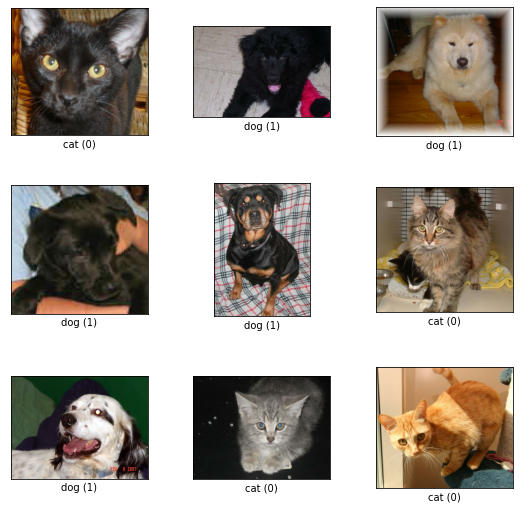

In [33]:
fig = tfds.show_examples(ds_train, ds_info)

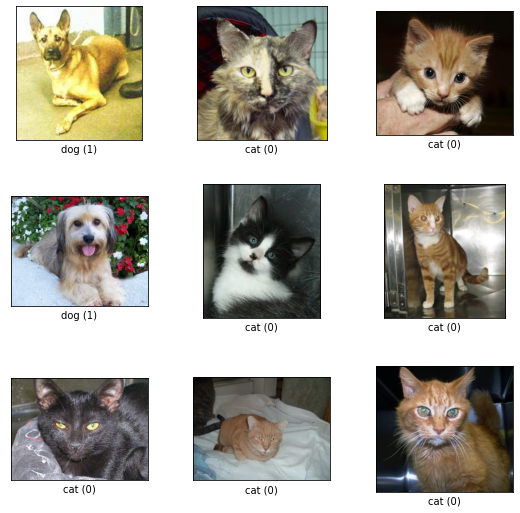

In [34]:
fig = tfds.show_examples(ds_test, ds_info)

In [35]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    with_info=True,
    as_supervised=True
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [36]:
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
581/581 [==============================] - 96s 166ms/step - loss: 1.1347 - accuracy: 0.5624 - val_loss: 1.8482 - val_accuracy: 0.5601
Epoch 2/15
581/581 [==============================] - 84s 145ms/step - loss: 0.9497 - accuracy: 0.6130 - val_loss: 3.3209 - val_accuracy: 0.5407
Epoch 3/15
581/581 [==============================] - 91s 156ms/step - loss: 0.8652 - accuracy: 0.6440 - val_loss: 1.3719 - val_accuracy: 0.5543
Epoch 4/15
581/581 [==============================] - 85s 146ms/step - loss: 0.7642 - accuracy: 0.6801 - val_loss: 0.8049 - val_accuracy: 0.6481
Epoch 5/15
581/581 [==============================] - 85s 146ms/step - loss: 0.6695 - accuracy: 0.7103 - val_loss: 1.2180 - val_accuracy: 0.6539
Epoch 6/15
581/581 [==============================] - 85s 146ms/step - loss: 0.5882 - accuracy: 0.7453 - val_loss: 0.7898 - val_accuracy: 0.6764
Epoch 7/15
581/581 [==============================] - 85s 146ms/step - loss: 0.4816 - accuracy: 0.7956 - val_loss: 0.6697 - val_ac

In [37]:
plain_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_34 = plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
581/581 [==============================] - 79s 137ms/step - loss: 0.8267 - accuracy: 0.5145 - val_loss: 0.8163 - val_accuracy: 0.5052
Epoch 2/15
581/581 [==============================] - 80s 138ms/step - loss: 0.7865 - accuracy: 0.5197 - val_loss: 1.1884 - val_accuracy: 0.5158
Epoch 3/15
581/581 [==============================] - 81s 139ms/step - loss: 0.7827 - accuracy: 0.5193 - val_loss: 1.0254 - val_accuracy: 0.5253
Epoch 4/15
581/581 [==============================] - 79s 137ms/step - loss: 0.7566 - accuracy: 0.5303 - val_loss: 2.6167 - val_accuracy: 0.5474
Epoch 5/15
581/581 [==============================] - 79s 137ms/step - loss: 0.7452 - accuracy: 0.5348 - val_loss: 0.7779 - val_accuracy: 0.5362
Epoch 6/15
581/581 [==============================] - 79s 137ms/step - loss: 0.7492 - accuracy: 0.5430 - val_loss: 0.7794 - val_accuracy: 0.5680
Epoch 7/15
581/581 [==============================] - 80s 137ms/step - loss: 0.7414 - accuracy: 0.5400 - val_loss: 0.8963 - val_ac

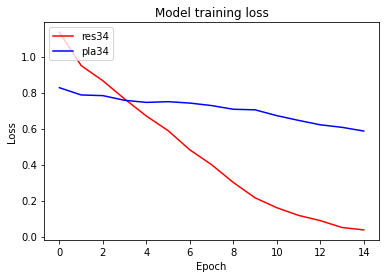

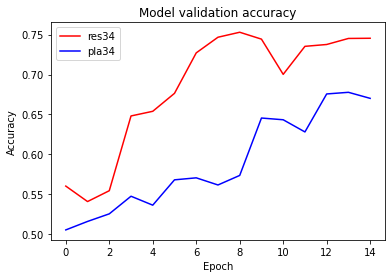

In [39]:
plot_loss_graph(history_resnet_34, history_plain_34, 34)
plot_acc_graph(history_resnet_34, history_plain_34, 34)

In [40]:
resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
581/581 [==============================] - 186s 320ms/step - loss: 1.5129 - accuracy: 0.5330 - val_loss: 1.4554 - val_accuracy: 0.5268
Epoch 2/15
581/581 [==============================] - 152s 262ms/step - loss: 1.2856 - accuracy: 0.5571 - val_loss: 2.3707 - val_accuracy: 0.5420
Epoch 3/15
581/581 [==============================] - 152s 261ms/step - loss: 1.1708 - accuracy: 0.5777 - val_loss: 4.3450 - val_accuracy: 0.5614
Epoch 4/15
581/581 [==============================] - 152s 262ms/step - loss: 1.0795 - accuracy: 0.5953 - val_loss: 1.3392 - val_accuracy: 0.5485
Epoch 5/15
581/581 [==============================] - 152s 262ms/step - loss: 1.0071 - accuracy: 0.6215 - val_loss: 0.9575 - val_accuracy: 0.6273
Epoch 6/15
581/581 [==============================] - 152s 262ms/step - loss: 0.9831 - accuracy: 0.6426 - val_loss: 1.6579 - val_accuracy: 0.5900
Epoch 7/15
581/581 [==============================] - 151s 260ms/step - loss: 0.9533 - accuracy: 0.6660 - val_loss: 1.8131 -

In [41]:
plain_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_50 = plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
581/581 [==============================] - 125s 215ms/step - loss: 0.8622 - accuracy: 0.5083 - val_loss: 0.7860 - val_accuracy: 0.5047
Epoch 2/15
581/581 [==============================] - 125s 215ms/step - loss: 0.8502 - accuracy: 0.5089 - val_loss: 1.1739 - val_accuracy: 0.5024
Epoch 3/15
581/581 [==============================] - 125s 216ms/step - loss: 0.8412 - accuracy: 0.5086 - val_loss: 1.7509 - val_accuracy: 0.5190
Epoch 4/15
581/581 [==============================] - 125s 215ms/step - loss: 0.8274 - accuracy: 0.5224 - val_loss: 2.1083 - val_accuracy: 0.5048
Epoch 5/15
581/581 [==============================] - 126s 216ms/step - loss: 0.8316 - accuracy: 0.5142 - val_loss: 2.4434 - val_accuracy: 0.5104
Epoch 6/15
581/581 [==============================] - 125s 216ms/step - loss: 0.8411 - accuracy: 0.5147 - val_loss: 0.8256 - val_accuracy: 0.4974
Epoch 7/15
581/581 [==============================] - 125s 216ms/step - loss: 0.8277 - accuracy: 0.5211 - val_loss: 0.7491 -

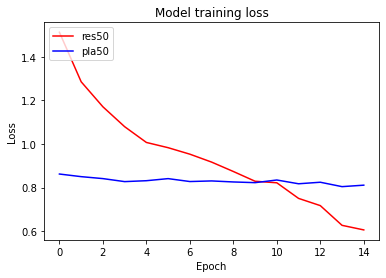

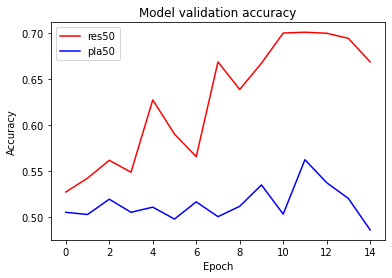

In [42]:
plot_loss_graph(history_resnet_50, history_plain_50, 50)
plot_acc_graph(history_resnet_50, history_plain_50, 50)

#### 추가 실험  
시간이 남으면 아래 카탈로그를 보고, tensorflow-datasets의 지원하는 다른 데이터셋에 실험을 해봅시다.
* https://www.tensorflow.org/datasets/catalog/overview

## 회고  
시작할 엄두가 안 나서 구글링을 통해 얻은 자료를 참고하여 (거의 복붙이지만) 코드를 따라 헀는데 자꾸 오류가 떠서 고작 이거 해결하는 것도 힘들었다. 왜...왜 똑같은 코드로 돌리는데도 오류가 뜰까...? 아직 이해가 안 가는 코드가 너무 많아서 어지럽다. 언젠가 이해가 가겠지... 시간 부족해서 추가실험같은 건 시도도 못했다. 아! 이건 불가능한 일이니까 띄어쓰기 "못 했다"로 써야 함

* 참고 : https://sike6054.github.io/blog/paper/first-post/
* 위 링크에서 논문 구현함  
* 그 밖의 참고 : https://dnddnjs.github.io/cifar10/2018/10/09/resnet/